In [1]:
%matplotlib inline

In [2]:
t_target = np.load("tng_t_target.npy")
lgt_target = np.log10(t_target)

In [3]:
pat_list = list(('11.75', '12.00', '12.25', '12.50', '12.75', '13.00',
                '13.25', '13.50', '13.75'))

mean_log_mah_targets = np.array(
    [np.load('mean_log_mah_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])
var_log_mah_targets = np.array(
    [np.load('var_log_mah_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])

mean_dmhdt_targets = np.array(
    [np.load('mean_dmhdt_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])
var_dmhdt_targets = np.array(
    [np.load('var_dmhdt_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])

lgmp_targets = np.array([float(lgm) for lgm in pat_list])


In [5]:
from diffmah.halo_population_assembly import _get_bimodal_halo_history
from diffmah.halo_population_assembly import LGE_ARR, LGL_ARR, X0_ARR
from diffmah.rockstar_pdf_model import DEFAULT_MAH_PDF_PARAMS

p_init_all = np.array(list(DEFAULT_MAH_PDF_PARAMS.values()))

_res = _get_bimodal_halo_history(lgt_target, lgmp_targets, LGE_ARR, LGL_ARR, X0_ARR, *p_init_all)
mean_log_mah_preds_i, var_log_mah_preds_i = _res[2], _res[4]

In [6]:
from jax import grad
from optimize_tng import mse_loss

def objective_fun(x, data):
    return float(mse_loss(x, data))

_objective_fun_jac = jjit(grad(mse_loss, argnums=0))

def objective_fun_jac(x, data):
    grads = _objective_fun_jac(x, data)
    return np.array(grads).astype('f8')

loss_data = (lgt_target, lgmp_targets, mean_log_mah_targets, 
              var_log_mah_targets, mean_dmhdt_targets, var_dmhdt_targets)

In [7]:
print(mse_loss(p_init_all, loss_data))
print(objective_fun(p_init_all, loss_data))
print(objective_fun_jac(p_init_all, loss_data))

0.022466911
0.022466911002993584
[-0.00563686 -0.00221709  0.00515471  0.00128439 -0.06285027 -0.07129687
  0.00930581  0.00387659 -0.00193133 -0.00328145 -0.0623881  -0.06074791
 -0.0039622  -0.00280644  0.02148623  0.02415831 -0.00700467 -0.00608838
 -0.00699835 -0.00241988 -0.05883775 -0.06289034 -0.02482708 -0.01676312
  0.02045453  0.00531518  0.00388458  0.00128061 -0.06612872 -0.0287504
 -0.02895708 -0.01726295  0.02464928  0.0263828   0.00766186 -0.00383809
 -0.01532764 -0.00450462]


In [8]:
from optimize_tng import BOUNDS
b = list(BOUNDS.values())

In [9]:
from scipy.optimize import minimize
m = 'L-BFGS-B'
res = minimize(objective_fun, p_init_all, args=(loss_data, ), method=m, jac=objective_fun_jac, bounds=b)
p_best = res.x
print("Optimizer successfully terminates? {}".format(res.success))

Optimizer successfully terminates? True


In [10]:
from collections import OrderedDict
d_best = OrderedDict([(key, val) for key, val in zip(BOUNDS.keys(), p_best)])

In [11]:
t_pred = np.linspace(1, 13.8, 500)
lgt_pred = np.log10(t_pred)
# lgmp_preds = np.concatenate(((11.5,), lgmp_targets, (15.0,)))
lgmp_preds = np.copy(lgmp_targets)

_res = _get_bimodal_halo_history(lgt_pred, lgmp_preds, LGE_ARR, LGL_ARR, X0_ARR, *p_best)
mean_dmhdt_preds_b, mean_mah_preds_b, mean_log_mah_preds_b, var_dmhdt_preds_b, var_log_mah_preds_b = _res

logmp = 12.00
logmp = 12.75
logmp = 13.50


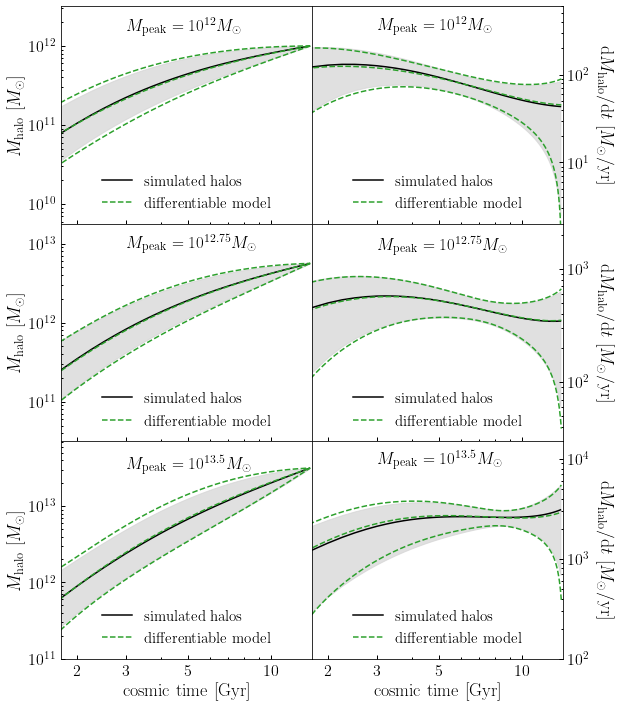

In [12]:
from matplotlib import ticker

fig, _axes = plt.subplots(3, 2, figsize=(9, 12), sharex=True)
((ax0, ax1), (ax2, ax3), (ax4, ax5)) = _axes
axes = ax0, ax1, ax2, ax3, ax4, ax5
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
for ax in axes:
    __=ax.loglog()
    __=ax.set_xticks((2, 3, 5, 10))
    __=ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
xlim = ax0.set_xlim(1.75, 14)
for ax in axes[1::2]:
    __=ax.yaxis.set_label_position("right")
    __=ax.yaxis.set_ticks_position("right")
    ylabel = ax.set_ylabel(r'${\rm d}M_{\rm halo}/{\rm d}t\ [M_{\odot}/{\rm yr}]$', labelpad=25, rotation=-90)
    
for ax in (ax4, ax5):
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')

for ax in axes[0::2]:
    ylabel = ax.set_ylabel(r'$M_{\rm halo}\ [M_{\odot}]$')

    
    
# UPPER LEFT
im = 1
lgm_plot = lgmp_targets[im]
ip = np.argmin(np.abs(lgmp_preds-lgm_plot))
print("logmp = {0:.2f}".format(lgm_plot))
ylim = ax0.set_ylim(10**(lgm_plot-2.25), 10**(lgm_plot+0.5))

ylo_target = mean_log_mah_targets[im, :]-np.sqrt(var_log_mah_targets[im, :])
yhi_target =  mean_log_mah_targets[im, :]+np.sqrt(var_log_mah_targets[im, :])
__=ax0.fill_between(10**lgt_target, 10**ylo_target, 10**yhi_target, color='lightgray', alpha=0.7)
__=ax0.plot(10**lgt_target, 10**mean_log_mah_targets[im, :], color='k', label=r'${\rm simulated\ halos}$')


mean_log_mah_pred_ip = mean_log_mah_preds_b[ip, :]
var_log_mah_pred_ip = var_log_mah_preds_b[ip, :]
ylo_pred_ip = mean_log_mah_pred_ip-np.sqrt(var_log_mah_pred_ip)
yhi_pred_ip =  mean_log_mah_pred_ip+np.sqrt(var_log_mah_pred_ip)
__=ax0.plot(10**lgt_pred, 10**mean_log_mah_pred_ip, '--', color=mgreen, label=r'${\rm differentiable\ model}$')
__=ax0.plot(10**lgt_pred, 10**ylo_pred_ip, '--', color=mgreen)
__=ax0.plot(10**lgt_pred, 10**yhi_pred_ip, '--', color=mgreen)


# UPPER RIGHT
__=ax1.set_ylim(2, 600)
ylo_target = mean_dmhdt_targets[im, :]-np.sqrt(var_dmhdt_targets[im, :])
yhi_target =  mean_dmhdt_targets[im, :]+np.sqrt(var_dmhdt_targets[im, :])
__=ax1.fill_between(10**lgt_target, ylo_target, yhi_target, color='lightgray', alpha=0.7)
__=ax1.plot(10**lgt_target, mean_dmhdt_targets[im, :], color='k', label=r'${\rm simulated\ halos}$')

mean_dmhdt_pred_ip = mean_dmhdt_preds_b[ip, :]
var_dmhdt_pred_ip = var_dmhdt_preds_b[ip, :]
ylo_pred_ip = mean_dmhdt_pred_ip-np.sqrt(var_dmhdt_pred_ip)
yhi_pred_ip =  mean_dmhdt_pred_ip+np.sqrt(var_dmhdt_pred_ip)
__=ax1.plot(10**lgt_pred, mean_dmhdt_pred_ip, '--', color=mgreen, label=r'${\rm differentiable\ model}$')
__=ax1.plot(10**lgt_pred, ylo_pred_ip, '--', color=mgreen)
__=ax1.plot(10**lgt_pred, yhi_pred_ip, '--', color=mgreen)



# MIDDLE LEFT
im = 4
lgm_plot = lgmp_targets[im]
ip = np.argmin(np.abs(lgmp_preds-lgm_plot))
print("logmp = {0:.2f}".format(lgm_plot))
ylim = ax2.set_ylim(10**(lgm_plot-2.25), 10**(lgm_plot+0.5))

ylo_target = mean_log_mah_targets[im, :]-np.sqrt(var_log_mah_targets[im, :])
yhi_target =  mean_log_mah_targets[im, :]+np.sqrt(var_log_mah_targets[im, :])
__=ax2.fill_between(10**lgt_target, 10**ylo_target, 10**yhi_target, color='lightgray', alpha=0.7)
__=ax2.plot(10**lgt_target, 10**mean_log_mah_targets[im, :], color='k', label=r'${\rm simulated\ halos}$')


mean_log_mah_pred_ip = mean_log_mah_preds_b[ip, :]
var_log_mah_pred_ip = var_log_mah_preds_b[ip, :]
ylo_pred_ip = mean_log_mah_pred_ip-np.sqrt(var_log_mah_pred_ip)
yhi_pred_ip =  mean_log_mah_pred_ip+np.sqrt(var_log_mah_pred_ip)
__=ax2.plot(10**lgt_pred, 10**mean_log_mah_pred_ip, '--', color=mgreen, label=r'${\rm differentiable\ model}$')
__=ax2.plot(10**lgt_pred, 10**ylo_pred_ip, '--', color=mgreen)
__=ax2.plot(10**lgt_pred, 10**yhi_pred_ip, '--', color=mgreen)


# MIDDLE RIGHT
__=ax3.set_ylim(30, 2_500)
ylo_target = mean_dmhdt_targets[im, :]-np.sqrt(var_dmhdt_targets[im, :])
yhi_target =  mean_dmhdt_targets[im, :]+np.sqrt(var_dmhdt_targets[im, :])
__=ax3.fill_between(10**lgt_target, ylo_target, yhi_target, color='lightgray', alpha=0.7)
__=ax3.plot(10**lgt_target, mean_dmhdt_targets[im, :], color='k', label=r'${\rm simulated\ halos}$')

mean_dmhdt_pred_ip = mean_dmhdt_preds_b[ip, :]
var_dmhdt_pred_ip = var_dmhdt_preds_b[ip, :]
ylo_pred_ip = mean_dmhdt_pred_ip-np.sqrt(var_dmhdt_pred_ip)
yhi_pred_ip =  mean_dmhdt_pred_ip+np.sqrt(var_dmhdt_pred_ip)
__=ax3.plot(10**lgt_pred, mean_dmhdt_pred_ip, '--', color=mgreen, label=r'${\rm differentiable\ model}$')
__=ax3.plot(10**lgt_pred, ylo_pred_ip, '--', color=mgreen)
__=ax3.plot(10**lgt_pred, yhi_pred_ip, '--', color=mgreen)


# LOWER LEFT
im = 7
lgm_plot = lgmp_targets[im]
ip = np.argmin(np.abs(lgmp_preds-lgm_plot))
print("logmp = {0:.2f}".format(lgm_plot))
ylim = ax4.set_ylim(10**(lgm_plot-2.5), 10**(lgm_plot+0.35))

ylo_target = mean_log_mah_targets[im, :]-np.sqrt(var_log_mah_targets[im, :])
yhi_target =  mean_log_mah_targets[im, :]+np.sqrt(var_log_mah_targets[im, :])
__=ax4.fill_between(10**lgt_target, 10**ylo_target, 10**yhi_target, color='lightgray', alpha=0.7)
__=ax4.plot(10**lgt_target, 10**mean_log_mah_targets[im, :], color='k', label=r'${\rm simulated\ halos}$')


mean_log_mah_pred_ip = mean_log_mah_preds_b[ip, :]
var_log_mah_pred_ip = var_log_mah_preds_b[ip, :]
ylo_pred_ip = mean_log_mah_pred_ip-np.sqrt(var_log_mah_pred_ip)
yhi_pred_ip =  mean_log_mah_pred_ip+np.sqrt(var_log_mah_pred_ip)
__=ax4.plot(10**lgt_pred, 10**mean_log_mah_pred_ip, '--', color=mgreen, label=r'${\rm differentiable\ model}$')
__=ax4.plot(10**lgt_pred, 10**ylo_pred_ip, '--', color=mgreen)
__=ax4.plot(10**lgt_pred, 10**yhi_pred_ip, '--', color=mgreen)


# LOWER RIGHT
__=ax5.set_ylim(100, 15_000)
ylo_target = mean_dmhdt_targets[im, :]-np.sqrt(var_dmhdt_targets[im, :])
yhi_target =  mean_dmhdt_targets[im, :]+np.sqrt(var_dmhdt_targets[im, :])
__=ax5.fill_between(10**lgt_target, ylo_target, yhi_target, color='lightgray', alpha=0.7)
__=ax5.plot(10**lgt_target, mean_dmhdt_targets[im, :], color='k', label=r'${\rm simulated\ halos}$')

mean_dmhdt_pred_ip = mean_dmhdt_preds_b[ip, :]
var_dmhdt_pred_ip = var_dmhdt_preds_b[ip, :]
ylo_pred_ip = mean_dmhdt_pred_ip-np.sqrt(var_dmhdt_pred_ip)
yhi_pred_ip =  mean_dmhdt_pred_ip+np.sqrt(var_dmhdt_pred_ip)
__=ax5.plot(10**lgt_pred, mean_dmhdt_pred_ip, '--', color=mgreen, label=r'${\rm differentiable\ model}$')
__=ax5.plot(10**lgt_pred, ylo_pred_ip, '--', color=mgreen)
__=ax5.plot(10**lgt_pred, yhi_pred_ip, '--', color=mgreen)


for ax in axes:
    leg = ax.legend(loc='lower center')

a = 3
__=ax0.annotate(r'$M_{\rm peak}=10^{12}M_{\odot}$', xy=(a, 10**12.2), xytext=(a, 10**12.2), size=17)
__=ax2.annotate(r'$M_{\rm peak}=10^{12.75}M_{\odot}$', xy=(a, 10**12.95), xytext=(a, 10**12.95), size=17)
__=ax4.annotate(r'$M_{\rm peak}=10^{13.5}M_{\odot}$', xy=(a, 10**13.5), xytext=(a, 10**13.5), size=17)

__=ax1.annotate(r'$M_{\rm peak}=10^{12}M_{\odot}$', xy=(a, 320), xytext=(a, 330), size=17)
__=ax3.annotate(r'$M_{\rm peak}=10^{12.75}M_{\odot}$', xy=(a, 1500), xytext=(a, 1500), size=17)
__=ax5.annotate(r'$M_{\rm peak}=10^{13.5}M_{\odot}$', xy=(a, 9_000), xytext=(a, 9_000), size=17)


fig.savefig('tng_pdf_model_valiation.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

In [13]:
pat_list = list(('11.50', '11.75', '12.00', '12.25', '12.50', '12.75', '13.00',
                '13.25', '13.50', '13.75'))

mean_log_mah_targets = np.array(
    [np.load('mean_log_mah_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])
var_log_mah_targets = np.array(
    [np.load('var_log_mah_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])

mean_dmhdt_targets = np.array(
    [np.load('mean_dmhdt_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])
var_dmhdt_targets = np.array(
    [np.load('var_dmhdt_tng_logmp_{}.npy'.format(lgmpat)) for lgmpat in pat_list])

lgmp_targets = np.array([float(lgm) for lgm in pat_list])

t_pred = np.linspace(1, 13.8, 500)
lgt_pred = np.log10(t_pred)

_res = _get_bimodal_halo_history(lgt_pred, lgmp_targets, LGE_ARR, LGL_ARR, X0_ARR, *p_best)
mean_dmhdt_preds_b, mean_mah_preds_b, mean_log_mah_preds_b, var_dmhdt_preds_b, var_log_mah_preds_b = _res

11.5
11.75
12.0
12.25
12.5
12.75
13.0
13.25
13.5
13.75


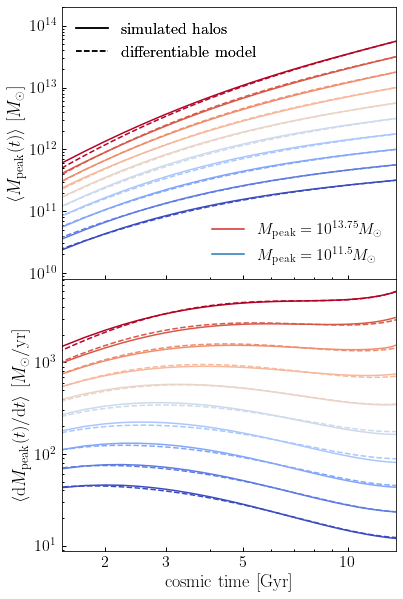

In [14]:
import matplotlib.cm as cm
from matplotlib import ticker
from matplotlib import lines as mlines

colormap_seq=np.linspace(0, 1, lgmp_targets.size)
colors=cm.coolwarm(colormap_seq)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 10), sharex=True)
fig.subplots_adjust(hspace=0)

xlim = ax0.set_xlim(1.5, 13.8)
ylim = ax0.set_ylim(8e9, 2e14)

__=ax0.loglog()
__=ax1.loglog()
for im in range(len(lgmp_targets)):
    lgm_plot = lgmp_targets[im]
    print(lgm_plot)
    __=ax0.plot(t_target, 10**mean_log_mah_targets[im, :], c=colors[im])
    __=ax1.plot(t_target, mean_dmhdt_targets[im, :], c=colors[im])
    __=ax0.plot(t_pred, 10**mean_log_mah_preds_b[im, :], '--', c=colors[im])
    __=ax1.plot(t_pred, mean_dmhdt_preds_b[im, :], '--', c=colors[im])



_xticks=ax0.set_xticks((2, 3, 5, 10))
__=ax0.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
__=ax0.get_xaxis().set_minor_formatter(ticker.NullFormatter())
xlabel = ax1.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax0.set_ylabel(r'$\langle M_{\rm peak}(t)\rangle\ [M_{\odot}]$')
ylabel = ax1.set_ylabel(r'$\langle{\rm d}M_{\rm peak}(t)/{\rm d}t\rangle\ [M_{\odot}/{\rm yr}]$')

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm peak}=10^{13.75}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm peak}=10^{11.5}M_{\odot}$')
first_legend=ax0.legend(handles=[red_line, blue_line], fontsize=16, loc='lower right')
__=ax0.add_artist(first_legend) 

solid_line=mlines.Line2D([],[],ls='-',c='k',label=r'${\rm simulated\ halos}$')
dashed_line=mlines.Line2D([],[],ls='--',c='k',label=r'${\rm differentiable\ model}$')
second_legend=ax0.legend(handles=[solid_line, dashed_line], fontsize=16, loc='upper left')
__=ax0.add_artist(second_legend)

fig.savefig('tng_pdf_model_avg_assembly_validation.png', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

In [17]:
for key, val in d_best.items():
    print("{0}={1:.2f},".format(key, val))

frac_late_ylo=0.55,
frac_late_yhi=0.75,
mean_lge_early_ylo=0.30,
mean_lge_early_yhi=0.74,
mean_lgl_early_ylo=-1.25,
mean_lgl_early_yhi=0.90,
mean_lgtc_early_ylo=-0.47,
mean_lgtc_early_yhi=-0.03,
cov_lge_lge_early_ylo=-0.50,
cov_lge_lge_early_yhi=-0.40,
cov_lgl_lgl_early_ylo=0.14,
cov_lgl_lgl_early_yhi=-1.33,
cov_lgtc_lgtc_early_ylo=-1.00,
cov_lgtc_lgtc_early_yhi=-1.20,
cov_lge_lgl_early_ylo=-0.33,
cov_lge_lgl_early_yhi=0.05,
cov_lge_lgtc_early_ylo=-0.13,
cov_lge_lgtc_early_yhi=-0.11,
cov_lgl_lgtc_early_ylo=0.05,
cov_lgl_lgtc_early_yhi=-0.35,
mean_lge_late_ylo=0.05,
mean_lge_late_yhi=0.64,
mean_lgl_late_ylo=-1.26,
mean_lgl_late_yhi=1.30,
mean_lgtc_late_ylo=0.35,
mean_lgtc_late_yhi=0.90,
cov_lge_lge_late_ylo=-1.25,
cov_lge_lge_late_yhi=-1.00,
cov_lgl_lgl_late_ylo=-0.38,
cov_lgl_lgl_late_yhi=-0.41,
cov_lgtc_lgtc_late_ylo=-1.00,
cov_lgtc_lgtc_late_yhi=-0.80,
cov_lge_lgl_late_ylo=-0.35,
cov_lge_lgl_late_yhi=-0.15,
cov_lge_lgtc_late_ylo=-0.35,
cov_lge_lgtc_late_yhi=-0.07,
cov_lgl_lgtc_late_y

In [16]:
for key, val in d_best.items():
    print("{0} {1:.2f} <= {2:.2f} <= {3:.3f},".format(key, BOUNDS[key][0], val, BOUNDS[key][1]))

frac_late_ylo 0.55 <= 0.55 <= 0.750,
frac_late_yhi 0.55 <= 0.75 <= 0.750,
mean_lge_early_ylo 0.30 <= 0.30 <= 0.500,
mean_lge_early_yhi 0.60 <= 0.74 <= 0.750,
mean_lgl_early_ylo -1.25 <= -1.25 <= -0.800,
mean_lgl_early_yhi 0.70 <= 0.90 <= 0.900,
mean_lgtc_early_ylo -0.75 <= -0.47 <= -0.250,
mean_lgtc_early_yhi -0.25 <= -0.03 <= -0.025,
cov_lge_lge_early_ylo -0.75 <= -0.50 <= -0.500,
cov_lge_lge_early_yhi -1.00 <= -0.40 <= -0.400,
cov_lgl_lgl_early_ylo -0.20 <= 0.14 <= 0.200,
cov_lgl_lgl_early_yhi -1.60 <= -1.33 <= -1.000,
cov_lgtc_lgtc_early_ylo -1.00 <= -1.00 <= -0.600,
cov_lgtc_lgtc_early_yhi -1.20 <= -1.20 <= -0.800,
cov_lge_lgl_early_ylo -0.35 <= -0.33 <= 0.050,
cov_lge_lgl_early_yhi -0.35 <= 0.05 <= 0.050,
cov_lge_lgtc_early_ylo -0.35 <= -0.13 <= 0.050,
cov_lge_lgtc_early_yhi -0.35 <= -0.11 <= 0.050,
cov_lgl_lgtc_early_ylo -0.35 <= 0.05 <= 0.050,
cov_lgl_lgtc_early_yhi -0.35 <= -0.35 <= 0.050,
mean_lge_late_ylo -0.10 <= 0.05 <= 0.050,
mean_lge_late_yhi 0.55 <= 0.64 <= 0.700,
mean_l